In [1]:
from systems.basesystem import System
from systems.positionsizing import PositionSizing
from systems.forecast_combine import ForecastCombine
from systems.forecast_scale_cap import ForecastScaleCap
from systems.trading_rules import TradingRule
from systems.forecasting import Rules
from systems.accounts.accounts_stage import Account
from systems.portfolio import Portfolios
from systems.rawdata import RawData
from systems.provided.rules.ewmac import ewmac, ewmac_calc_vol
from systems.provided.rules.breakout import breakout
from systems.provided.rules.accel import accel
from sysdata.sim.db_equities_sim_data import dbEquitiesSimData
from sysdata.config.configdata import Config

import matplotlib.pyplot as plt

In [2]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    # miny, maxy = ax1.get_ylim()
    # ax1.set_ylim(miny+dy, maxy+dy)
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)


def align_yaxis(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = (ax1, ax2)
    extrema = [ax.get_ylim() for ax in axes]
    tops = [extr[1] / (extr[1] - extr[0]) for extr in extrema]
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [list(reversed(l)) for l in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    b_new_t = extrema[0][0] + tot_span * (extrema[0][1] - extrema[0][0])
    t_new_b = extrema[1][1] - tot_span * (extrema[1][1] - extrema[1][0])
    axes[0].set_ylim(extrema[0][0], b_new_t)
    axes[1].set_ylim(t_new_b, extrema[1][1])


In [3]:
rules = Rules(dict(
    mac4 = TradingRule(ewmac, ['rawdata.get_daily_prices', 'rawdata.daily_returns_volatility'], {'Lfast':4, 'Lslow':16}),
    mac8 = TradingRule(ewmac, ['rawdata.get_daily_prices', 'rawdata.daily_returns_volatility'], {'Lfast':8, 'Lslow':32}),
    mac16 = TradingRule(ewmac, ['rawdata.get_daily_prices', 'rawdata.daily_returns_volatility'], {'Lfast':16, 'Lslow':64}),
    mac32 = TradingRule(ewmac, ['rawdata.get_daily_prices', 'rawdata.daily_returns_volatility'], {'Lfast':32, 'Lslow':128}),
    mac64 = TradingRule(ewmac, ['rawdata.get_daily_prices', 'rawdata.daily_returns_volatility'], {'Lfast':64, 'Lslow':256}),

    normmom2 = TradingRule(ewmac_calc_vol, ['rawdata.get_cumulative_daily_vol_normalised_returns'], {'Lfast':2, 'Lslow':8}),
    normmom4 = TradingRule(ewmac_calc_vol, ['rawdata.get_cumulative_daily_vol_normalised_returns'], {'Lfast':4, 'Lslow':16}),
    normmom8 = TradingRule(ewmac_calc_vol, ['rawdata.get_cumulative_daily_vol_normalised_returns'], {'Lfast':8, 'Lslow':32}),
    normmom16 = TradingRule(ewmac_calc_vol, ['rawdata.get_cumulative_daily_vol_normalised_returns'], {'Lfast':16, 'Lslow':64}),
    normmom32 = TradingRule(ewmac_calc_vol, ['rawdata.get_cumulative_daily_vol_normalised_returns'], {'Lfast':32, 'Lslow':128}),
    normmom64 = TradingRule(ewmac_calc_vol, ['rawdata.get_cumulative_daily_vol_normalised_returns'], {'Lfast':64, 'Lslow':256}),
    
    breakout10 = TradingRule(breakout, [], {'lookback':10}),
    breakout20 = TradingRule(breakout, [], {'lookback':20}),
    breakout40 = TradingRule(breakout, [], {'lookback':40}),
    breakout80 = TradingRule(breakout, [], {'lookback':80}),
    breakout160 = TradingRule(breakout, [], {'lookback':160}),
    breakout320 = TradingRule(breakout, [], {'lookback':320}),

    accel16 = TradingRule(accel, ['rawdata.get_daily_prices', 'rawdata.daily_returns_volatility'], {'Lfast':16}),
    accel32 = TradingRule(accel, ['rawdata.get_daily_prices', 'rawdata.daily_returns_volatility'], {'Lfast':32}),
    accel64 = TradingRule(accel, ['rawdata.get_daily_prices', 'rawdata.daily_returns_volatility'], {'Lfast':64}),
))

instrument_weights = dict(
    IWD = 0.33,
    IWF = 0.33,
    EEM = 0.33,
    TLT = 0.2,
    IEF = 0.2,
    HYG = 0.2,
    LQD = 0.2,
    PFIX = 0.2,
    GLD = 0.5,
    BITO = 0.5,
    PDBC = 1,
    KRBN = 0.2,
)

instruments = list(instrument_weights.keys())

config = Config(['private.estimates.yaml'])

system = System([rules, RawData(), ForecastScaleCap(), ForecastCombine(), PositionSizing(), Account(), Portfolios()], data=dbEquitiesSimData(), config=config)
system.config.start_date = '2020-07-17'
system.config.notional_trading_capital = 1000000
system.config.percentage_vol_target = 24
system.config.instrument_weights = instrument_weights
# system.config.instrument_div_multiplier = 1.9
# system.config.use_instrument_div_mult_estimates = True
# system.config.use_instrument_weight_estimates = True
# system.config.use_forecast_scale_estimates = True
# system.config.use_forecast_div_mult_estimates = True
# system.config.use_forecast_weight_estimates = True
system.config.capital_multiplier['func'] = 'syscore.capital.full_compounding'
system.get_instrument_list()


2022-07-23 10:51:38 {'type': 'dbEquitiesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)


['BITO',
 'EEM',
 'GLD',
 'HYG',
 'IEF',
 'IWD',
 'IWF',
 'KRBN',
 'LQD',
 'PDBC',
 'PFIX',
 'TLT']

/mnt/d/Users/Mike/src/pysystemtrade/sysobjects/equities_prices.py:20: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


2022-07-23 10:51:40 {'type': 'base_system', 'stage': 'combForecast', 'instrument_code': 'IWD'} [Warning] WARNING: No forecast weights  - using equal weights of 0.050 over all 20 trading rules in system
2022-07-23 10:52:04 {'type': 'base_system', 'stage': 'combForecast', 'instrument_code': 'IWF'} [Warning] WARNING: No forecast weights  - using equal weights of 0.050 over all 20 trading rules in system
2022-07-23 10:52:05 {'type': 'base_system', 'stage': 'combForecast', 'instrument_code': 'EEM'} [Warning] WARNING: No forecast weights  - using equal weights of 0.050 over all 20 trading rules in system
2022-07-23 10:52:05 {'type': 'base_system', 'stage': 'combForecast', 'instrument_code': 'TLT'} [Warning] WARNING: No forecast weights  - using equal weights of 0.050 over all 20 trading rules in system
2022-07-23 10:52:05 {'type': 'base_system', 'stage': 'combForecast', 'instrument_code': 'IEF'} [Warning] WARNING: No forecast weights  - using equal weights of 0.050 over all 20 trading rules 

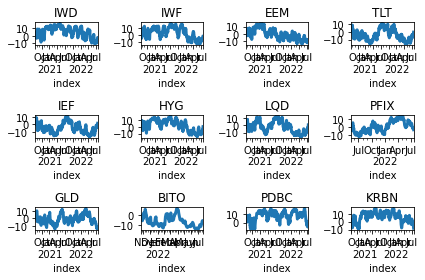

In [4]:
import math
plt.rc('figure', figsize=(20, 20))

n_instruments = len(instruments)
dim = 4
pos = (math.ceil(n_instruments/4), dim)

fig, ax = plt.subplots(*pos)
for i, instrument in enumerate(instruments):
    axis = ax[i//dim][i%dim]
    axis.set_title(instrument)
    system.combForecast.get_combined_forecast(instrument).plot(ax=axis, lw=3)

plt.tight_layout()

/mnt/d/Users/Mike/src/pysystemtrade/sysobjects/equities_prices.py:20: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


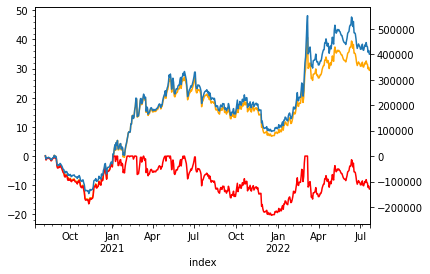

In [5]:
portfolio = system.accounts.portfolio_with_multiplier()
fig, ax1 = plt.subplots()
portfolio.percent.curve().plot(ax=ax1, color='orange')
portfolio.percent.drawdown().plot(ax=ax1, color='red')
ax2 = ax1.twinx()
portfolio.curve().plot(ax=ax2)

align_yaxis(ax1,ax2)
# ax1.set_yticks(step=25)
ax1.minorticks_on()
plt.show()


In [6]:
portfolio.percent.stats()

[[('min', '-10.63'),
  ('max', '4.654'),
  ('median', '0.08966'),
  ('mean', '0.05786'),
  ('std', '1.323'),
  ('skew', '-1.4'),
  ('ann_mean', '14.36'),
  ('ann_std', '21.17'),
  ('sharpe', '0.6783'),
  ('sortino', '0.7657'),
  ('avg_drawdown', '-7.913'),
  ('time_in_drawdown', '0.9412'),
  ('calmar', '0.7067'),
  ('avg_return_to_drawdown', '1.815'),
  ('avg_loss', '-0.9678'),
  ('avg_gain', '0.8913'),
  ('gaintolossratio', '0.9209'),
  ('profitfactor', '1.139'),
  ('hitrate', '0.5528'),
  ('t_stat', '0.9875'),
  ('p_value', '0.3239')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent'])]

In [7]:
import pandas as pd

def get_percent_portfolio_weight(instrument):
    return system.accounts.get_actual_position(instrument)*system.data.daily_prices(instrument)/system.accounts.get_actual_capital()

weights = pd.DataFrame()
for i in system.get_instrument_list():
    weights[i] = get_percent_portfolio_weight(i)

weights



,BITO,EEM,GLD,HYG,IEF,IWD,IWF,KRBN,LQD,PDBC,PFIX,TLT
index,,,,,,,,,,,,
2020-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-18,-0.032373,-0.173643,-0.489455,-0.089000,-0.046819,-0.130513,-0.082263,-0.031365,-0.076231,-0.130958,-0.007999,-0.043093
2022-07-19,-0.026319,-0.144533,-0.486429,-0.059939,-0.072951,-0.078349,-0.052683,-0.026211,-0.074735,-0.105428,-0.005937,-0.055811
2022-07-20,-0.023415,-0.141371,-0.504810,-0.042296,-0.093542,-0.057181,-0.034591,-0.041519,-0.079890,-0.098212,-0.004248,-0.059286


In [10]:
from sysbrokers.IB.utils import write_ibkr_rebalance_file

current_weights = {k:v for k,v in zip(weights.columns, weights[-1:].values[0])}
current_weights

write_ibkr_rebalance_file('trend_following_long_short_v1', current_weights, leverage=1)

In [9]:
from systems.diagoutput import systemDiag
from syscore.fileutils import get_filename_for_package

diag = systemDiag(system)
display(diag.output_config_with_estimated_parameters())

def save_estimated_system(system, package):
    filename=get_filename_for_package(package)
    sysdiag = systemDiag(system)
    sysdiag.yaml_config_with_estimated_parameters(filename,
                                                attr_names=['forecast_scalars',
                                                            'forecast_weights',
                                                            'forecast_div_multiplier',
                                                            'forecast_mapping',
                                                            'instrument_weights',
                                                            'instrument_div_multiplier'])

save_estimated_system(system, 'private.estimates-test.yaml')

Can't output forecast scalar estimates, as they weren't estimated
BITO avg position 1556.90
Forecast scaling not required for BITO
EEM avg position 4055.81
Forecast scaling not required for EEM
GLD avg position 2116.83
Forecast scaling not required for GLD
HYG avg position 5142.05
Forecast scaling not required for HYG
IEF avg position 3642.69
Forecast scaling not required for IEF
IWD avg position 1704.57
Forecast scaling not required for IWD
IWF avg position 725.50
Forecast scaling not required for IWF
KRBN avg position 1976.28
Forecast scaling not required for KRBN
LQD avg position 2488.24
Forecast scaling not required for LQD
PDBC avg position 49735.92
Forecast scaling not required for PDBC
PFIX avg position 1112.93
Forecast scaling not required for PFIX
TLT avg position 1086.08
Forecast scaling not required for TLT


{'forecast_scalars': {'mac4': 9.700767113722238,
  'mac8': 6.717710116740956,
  'mac16': 4.5863893336307235,
  'mac32': 3.0478987757984703,
  'mac64': 2.076694567875056,
  'normmom2': 37.70161004869841,
  'normmom4': 26.95378612427337,
  'normmom8': 18.946955438397936,
  'normmom16': 12.840675303608892,
  'normmom32': 8.533431604020548,
  'normmom64': 5.643113169583672,
  'breakout10': 0.7151196872142512,
  'breakout20': 0.8034454004076605,
  'breakout40': 0.8336451159715176,
  'breakout80': 0.8323388153658435,
  'breakout160': 0.8052740245281022,
  'breakout320': 0.784142299103877,
  'accel16': 7.296201444738374,
  'accel32': 4.997327387169841,
  'accel64': 3.450348375564261},
 'forecast_weights': {'BITO': {'mac64': 0.054073299442832345,
   'mac16': 0.054073299442832345,
   'mac8': 0.054073299442832345,
   'accel16': 0.05235268605346368,
   'accel64': 0.04770855781869837,
   'normmom8': 0.05279700450160666,
   'breakout160': 0.04327566246423675,
   'normmom2': 0.05279700450160666,
   

Can't output forecast scalar estimates, as they weren't estimated
BITO avg position 1556.90
Forecast scaling not required for BITO
EEM avg position 4055.81
Forecast scaling not required for EEM
GLD avg position 2116.83
Forecast scaling not required for GLD
HYG avg position 5142.05
Forecast scaling not required for HYG
IEF avg position 3642.69
Forecast scaling not required for IEF
IWD avg position 1704.57
Forecast scaling not required for IWD
IWF avg position 725.50
Forecast scaling not required for IWF
KRBN avg position 1976.28
Forecast scaling not required for KRBN
LQD avg position 2488.24
Forecast scaling not required for LQD
PDBC avg position 49735.92
Forecast scaling not required for PDBC
PFIX avg position 1112.93
Forecast scaling not required for PFIX
TLT avg position 1086.08
Forecast scaling not required for TLT
